# Install Libraries

In [1]:
!pip install tensorflow==2.8
!pip install ipython-autotime
!pip install pillow-avif-plugin

%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.5/497.5 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 72.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.11.2
    Uninstalling tensorboard-2.11.2:
      Successfully uninstalled tensorboard-2.11.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.11.0
    Uninstalling tensorflow-2.11.0:
      Successfully uninstalled tensorflow-2.11.0
ERROR: pip's dependency resolver does not currently take into account all the pack

## Imports 

In [2]:
import random
import os

import warnings
warnings.simplefilter("ignore")

from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

import PIL
import PIL.Image
import pillow_avif

import cv2

import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import joblib

import tensorflow
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

tf.__version__

'2.8.0'

time: 5.97 s (started: 2023-04-30 00:41:18 +00:00)


# TPU Configuration

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1
time: 2.24 ms (started: 2023-04-30 00:41:24 +00:00)


# Load Data

In [4]:
METADATA_PATH = "/kaggle/input/clc-metadata-generation/landmarks_data.csv"

time: 6.05 ms (started: 2023-04-30 00:41:24 +00:00)


In [5]:
df = pd.read_csv(METADATA_PATH)
df.sort_values(
    by=['category', 'landmark', "img_path"], 
    inplace=True, 
    ignore_index=True
)
df = df[["category","landmark","img_path"]]
df.head()

category           landmark  \
0   Gothic  ChartresCathedral   
1   Gothic  ChartresCathedral   
2   Gothic  ChartresCathedral   
3   Gothic  ChartresCathedral   
4   Gothic  ChartresCathedral   

                                            img_path  
0  /kaggle/input/landmarks-dataset/Gothic/Chartre...  
1  /kaggle/input/landmarks-dataset/Gothic/Chartre...  
2  /kaggle/input/landmarks-dataset/Gothic/Chartre...  
3  /kaggle/input/landmarks-dataset/Gothic/Chartre...  
4  /kaggle/input/landmarks-dataset/Gothic/Chartre...

time: 41.6 ms (started: 2023-04-30 00:41:24 +00:00)


# Data Preparation 

In [6]:
img_height = 224
img_width = 224

time: 476 µs (started: 2023-04-30 00:41:24 +00:00)


In [7]:
def read_imgs(path_to_image):
    image = PIL.Image.open(path_to_image).convert("RGB")
    image = np.asarray(image.resize((img_height, img_width)))
    return image 

time: 1.81 ms (started: 2023-04-30 00:41:24 +00:00)


## Encoding categorical labels 
There are 6 categories, and for each category there are 5 landmarks

- `category` - [0,1,0,0,0,0]
- `landmark` for a category - [0,1,0,0,0, 0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0]

In [8]:
lb_category = LabelBinarizer()
category_enc = lb_category.fit(df["category"])
y_category = lb_category.transform(df["category"])

with open("category_encoder.pkl", "wb") as f:
    joblib.dump(category_enc, f)

# Labels
print('Category classes:')
pd.DataFrame(
    zip(
        lb_category.classes_, np.unique(np.argmax(y_category, axis = 1))
    ), 
    columns = ["category_name", "label"]
)

Category classes:


category_name  label
0        Gothic      0
1        Modern      1
2        Mughal      2
3  Neoclassical      3
4       Pagodas      4
5      Pyramids      5

time: 12.7 ms (started: 2023-04-30 00:41:24 +00:00)


In [9]:
lb_landmark = LabelBinarizer()
landmark_enc = lb_landmark.fit(df["landmark"])
y_landmark = lb_landmark.transform(df["landmark"])

with open("landmark_encoder.pkl", "wb") as f:
    joblib.dump(landmark_enc, f)
    
# Labels
print('Landmark classes:')
pd.DataFrame(
    zip(
        lb_landmark.classes_, np.unique(np.argmax(y_landmark, axis = 1))
    ), 
    columns = ["landmark_name", "label"]
)

Landmark classes:


landmark_name  label
0                 Academy of Athens      0
1                   Bibi Ka Maqbara      1
2                 Buckingham Palace      2
3                 CCTV Headquarters      3
4             Cathedral of Bras�lia      4
5                 ChartresCathedral      5
6                 Chrysler Building      6
7                  CologneCathedral      7
8                     Concertgebouw      8
9         El Castillo, Chichen Itza      9
10               FogongTemplePagoda     10
11             GiantWildGoosePagoda     11
12                  Hallgr�mskirkja     12
13                      Jama Masjid     13
14                   Louvre Pyramid     14
15                   MilanCathedral     15
16              Notre-DameCathedral     16
17                         Panth�on     17
18                Pyramid of Djoser     18
19                  Pyramid of Giza     19
20                   Ripon Building     20
21  Santa Cecilia Acatitlan Pyramid     21
22                  ShwedagonPagoda     22
23                St.VitusCathedral     23
24                        Taj Mahal     24
25                    ThienMuPagoda     25
26             TianningTemplePagoda     26
27                    Tomb of Akbar     27
28        Tomb of I_timad-ud-Daulah     28
29                           eiffel     29

time: 14 ms (started: 2023-04-30 00:41:24 +00:00)


## Spliting the dataset into Train, Validation & Test sets  

In [10]:
# Train and Test Split
train, test = train_test_split(
    df, test_size = 0.1, shuffle = True, random_state = 1, stratify=df[['category', 'landmark']]
)

# Train and Validation Split
train, val = train_test_split(
    train, test_size = 0.2, stratify=train[['category', 'landmark']]
)

train_x, cat_y_train, land_y_train = train["img_path"], train["category"], train["landmark"]
val_x, cat_y_val, land_y_val = val["img_path"], val["category"], val["landmark"]
test_x, cat_y_test ,land_y_test = test["img_path"], test["category"], test["landmark"]

# Reading Images
train_x = np.array([read_imgs(i) for i in tqdm(train_x)])
val_x = np.array([read_imgs(i) for i in tqdm(val_x)])
test_x = np.array([read_imgs(i) for i in tqdm(test_x)])

cat_y_train, land_y_train = lb_category.transform(cat_y_train), lb_landmark.transform(land_y_train)
cat_y_val, land_y_val = lb_category.transform(cat_y_val), lb_landmark.transform(land_y_val)
cat_y_test, land_y_test = lb_category.transform(cat_y_test), lb_landmark.transform(land_y_test)

# Scale the images
train_x, val_x, test_x = np.array(train_x) / 255.0, np.array(val_x) / 255.0, np.array(test_x) / 255.0

# Shapes and size of dataset
train_x.shape, val_x.shape, test_x.shape

100%|██████████| 42/42 [00:01<00:00, 24.55it/s]


((302, 224, 224, 3), (76, 224, 224, 3), (42, 224, 224, 3))

time: 25.3 s (started: 2023-04-30 00:41:24 +00:00)


# Convert to Tensorflow dataset

In [12]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

if tpu is None:
    BATCH_SIZE = BATCH_SIZE * 2

time: 54.6 ms (started: 2023-04-30 00:41:49 +00:00)


In [13]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices(
        (train_x, cat_y_train, land_y_train)
    )
    .map(
        lambda image, category, landmark: (
            image, {"category": category, "landmark": landmark}
        )
    )
    .repeat()
    .shuffle(16)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices(
        (val_x, cat_y_val, land_y_val)
    )
    .map(
        lambda image, category, landmark: (
            image, {"category": category, "landmark": landmark}
        )
    )
    .repeat()
    .shuffle(8)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(
        (test_x, cat_y_test ,land_y_test)
    )
    .map(
        lambda image, category, landmark: (
            image, {"category": category, "landmark": landmark}
        )
    )
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

time: 3.29 s (started: 2023-04-30 00:41:49 +00:00)


## Accessing and Plotting data 

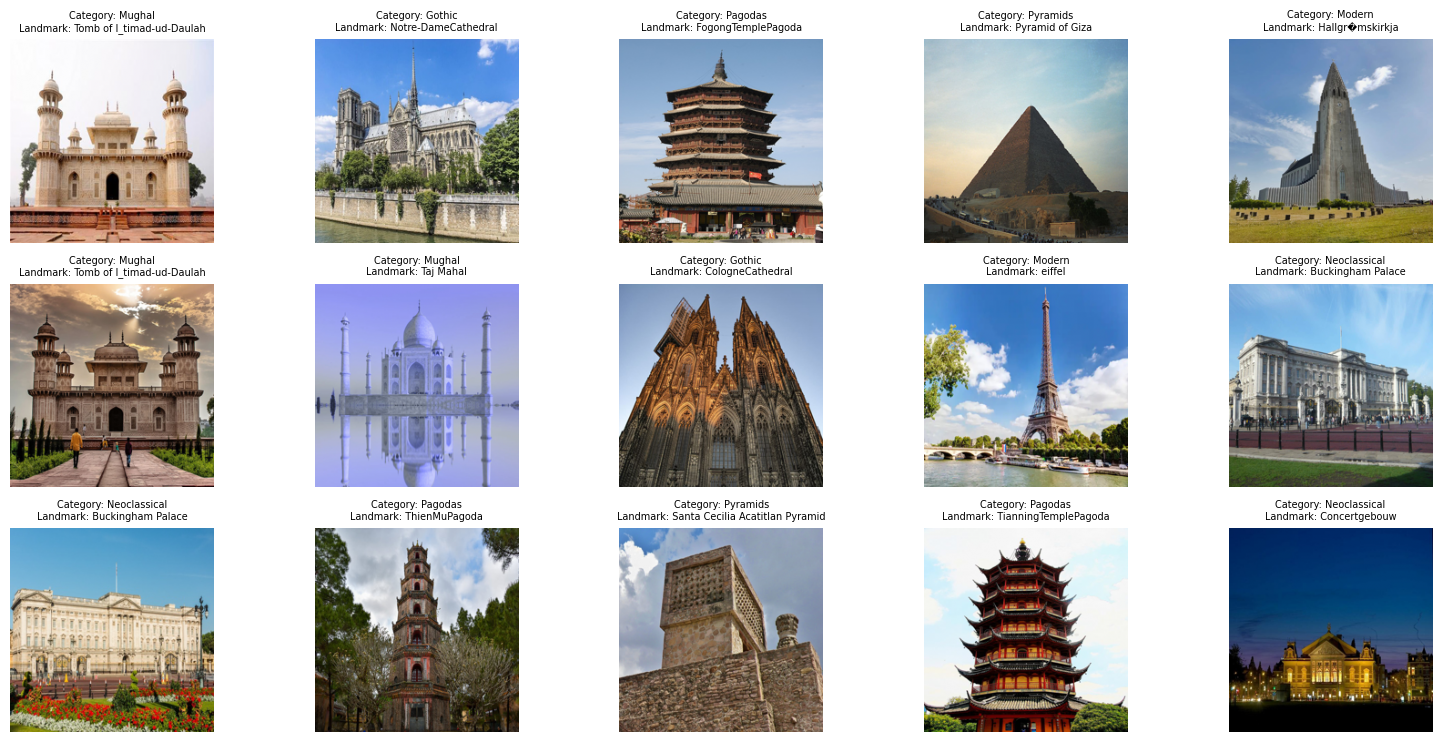

time: 1.62 s (started: 2023-04-30 00:41:52 +00:00)


In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(19, 9))
for images, labels in train_dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy())
        
        cat_ = lb_category.classes_[np.argmax(labels["category"][i])]
        land_ = lb_landmark.classes_[np.argmax(labels["landmark"][i])]
        
        plt.title(f"Category: {cat_}\nLandmark: {land_}", fontdict={"fontsize":7})
        plt.axis("off")

# Building Model

In [15]:
INPUT_SHAPE = (224, 224, 3)

NUM_CATEGORY_CLASSES = 6
NUM_LANDMARK_CLASSES = 30

EPOCHS = 65
TRAIN_STEPS = train_x.shape[0] // BATCH_SIZE
VALIDATION_STEPS = val_x.shape[0] // BATCH_SIZE

EFN_B0_NOISY_STUDENT_WTS_PATH = (
    "/kaggle/input/efficientnet-keras-noisystudent-weights-b0b7"
    "/noisystudent/noisy.student.notop-b0.h5"
) 

TFHUB_EFFICIENTNETB0 = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

time: 1.35 ms (started: 2023-04-30 00:41:54 +00:00)


## Image Augmentation 

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.2),
        layers.RandomFlip(mode="horizontal"),
#         layers.RandomBrightness(factor=0.45, value_range=(0, 1)),
        layers.RandomZoom(0.2, 0.2),
        layers.RandomContrast(factor=0.3),
        layers.RandomHeight(0.2),
        layers.RandomWidth(0.2),
    ],
    name="image_augmentation",
)

time: 32.2 ms (started: 2023-04-30 00:41:54 +00:00)


## EffiecientNet

In [17]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model


def build_model(): 
    inputs = layers.Input(shape = INPUT_SHAPE)
    img_aug = img_augmentation(inputs)
    
    efn = hub.KerasLayer(
        TFHUB_EFFICIENTNETB0, 
        trainable=False,
        name = "efficientnet_b0"
    )(img_aug)
    
    # Fine tuning
    mod = layers.Flatten()(efn)
    mod = layers.Dense(1024, activation='swish')(mod)
    mod = layers.Dropout(0.3, name="top_dropout")(mod)
    
    # Category Branch
    cat = layers.Dense(128, activation='swish')(mod)
    cat = layers.BatchNormalization()(cat)
    cat = layers.Dropout(0.5)(cat)
    cat = layers.Dense(
        NUM_CATEGORY_CLASSES, activation="softmax", name="category"
    )(cat)
    
    # Landmark Branch
    land = layers.Dense(128, activation='swish')(mod)
    land = layers.BatchNormalization()(land)
    land = layers.Dropout(0.5)(land)
    land = layers.Dense(
        NUM_LANDMARK_CLASSES, activation="softmax", name="landmark"
    )(land)
    
    # Fit the inputs and outputs from all branches
    model = Model(inputs = inputs, outputs = [cat, land], name="EfficientNet")
    
    # Compile the model
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), 
        loss_weights={
            'category': 1,
            'landmark': 1
        },
        loss = {
            'category': 'categorical_crossentropy',
            'landmark': 'categorical_crossentropy'
        },  
        metrics = {
            'category': tfa.metrics.F1Score(num_classes=NUM_CATEGORY_CLASSES),
            'landmark': tfa.metrics.F1Score(num_classes=NUM_LANDMARK_CLASSES)
        }
    )
    return model

time: 2.31 ms (started: 2023-04-30 00:41:54 +00:00)


In [18]:
# Clear backend sessions to reset name counters
tf.keras.backend.clear_session()

with strategy.scope():
    model = build_model()
    
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 image_augmentation (Sequential  (None, None, None,   0          ['input_1[0][0]']                
 )                              3)                                                                
                                                                                                  
 efficientnet_b0 (KerasLayer)   (None, 1280)         4049564     ['image_augmentation[0][0]']     
                                                                                       

#### Plot the model

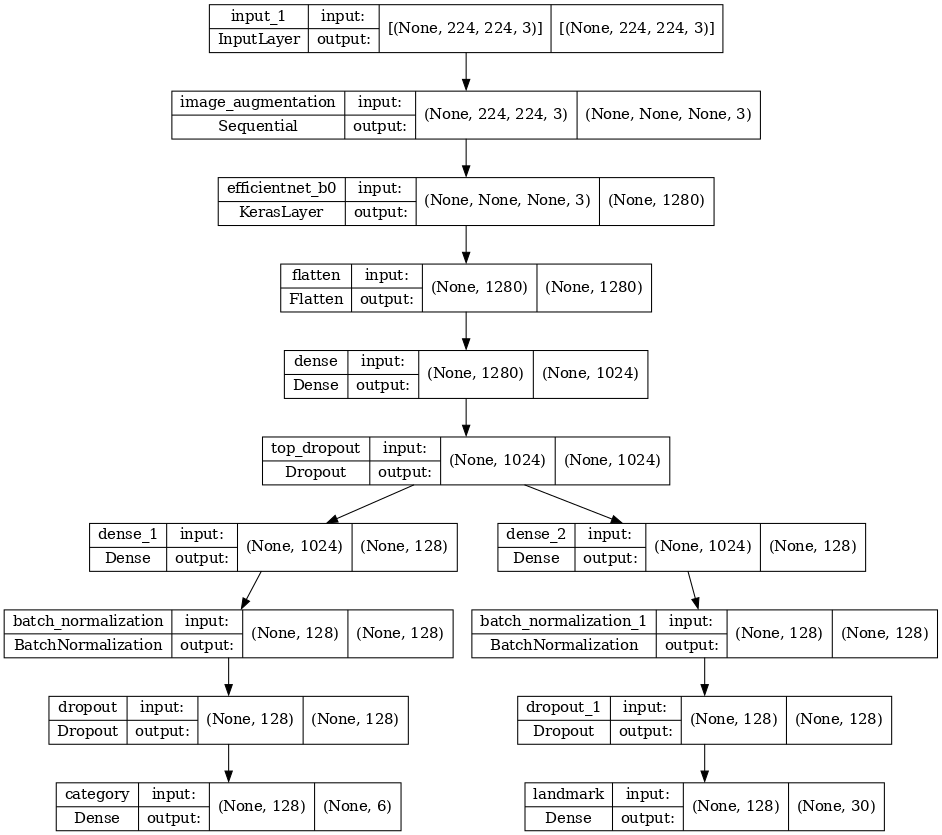

time: 434 ms (started: 2023-04-30 00:42:05 +00:00)


In [19]:
tf.keras.utils.plot_model(model, to_file="category_and_landmark_classifier.png", show_shapes=True, dpi=75)

## Fit the model 

In [20]:
checkpoint = ModelCheckpoint(
    'saved_model/cat_land_best_model', 
    save_best_only = True, 
    monitor = 'val_loss'
)

early_stopping = EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True
)

history = model.fit(
    train_dataset, 
    validation_data = valid_dataset,
    steps_per_epoch = TRAIN_STEPS,
    validation_steps = VALIDATION_STEPS,
    epochs = EPOCHS, 
    callbacks = [checkpoint, early_stopping]
)

Epoch 1/65
9/9 [==============================] - 44s 3s/step - loss: 5.2359 - category_loss: 1.4147 - landmark_loss: 3.8213 - category_f1_score: 0.5448 - landmark_f1_score: 0.1103 - val_loss: 3.9280 - val_category_loss: 1.0229 - val_landmark_loss: 2.9051 - val_category_f1_score: 0.9077 - val_landmark_f1_score: 0.2948
Epoch 2/65
9/9 [==============================] - 25s 3s/step - loss: 2.5331 - category_loss: 0.4862 - landmark_loss: 2.0469 - category_f1_score: 0.8367 - landmark_f1_score: 0.4194 - val_loss: 3.2010 - val_category_loss: 0.7331 - val_landmark_loss: 2.4679 - val_category_f1_score: 0.8546 - val_landmark_f1_score: 0.5198
Epoch 3/65
9/9 [==============================] - 25s 3s/step - loss: 1.8108 - category_loss: 0.4071 - landmark_loss: 1.4037 - category_f1_score: 0.8254 - landmark_f1_score: 0.5935 - val_loss: 2.7237 - val_category_loss: 0.5607 - val_landmark_loss: 2.1630 - val_category_f1_score: 0.9506 - val_landmark_f1_score: 0.6597
Epoch 4/65
9/9 [========================

In [21]:
model.save_weights("./checkpoints/cat_land_model/cat_land_model")

time: 769 ms (started: 2023-04-30 00:55:57 +00:00)


In [22]:
model.save('clc_classifier_model_tf28.h5')

time: 310 ms (started: 2023-04-30 00:55:57 +00:00)


## Plot learning curves

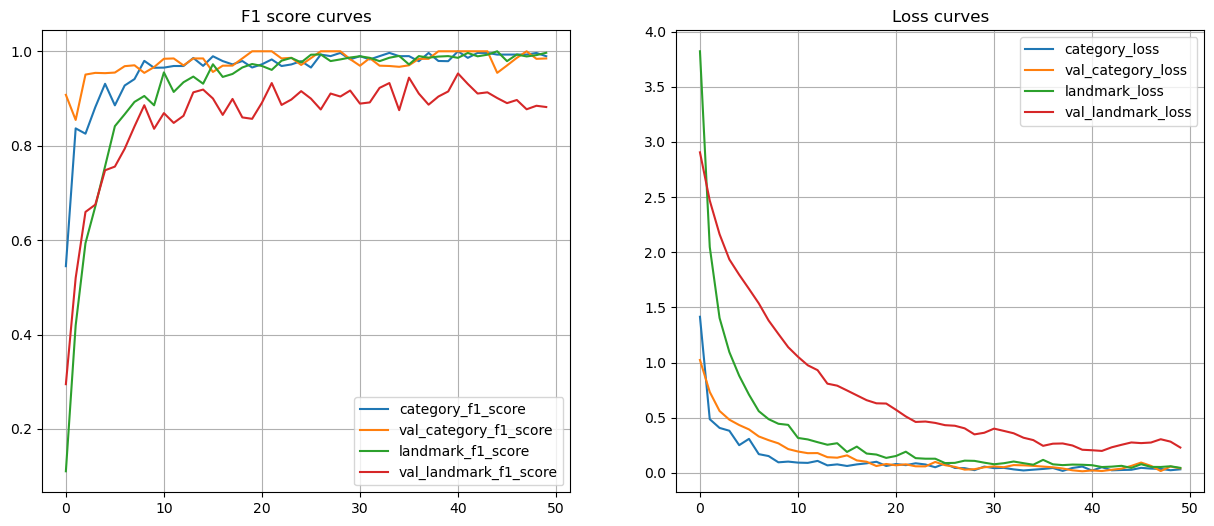

time: 471 ms (started: 2023-04-30 00:55:58 +00:00)


In [23]:
H = history.history
fig = plt.figure(figsize = (15, 6))

c = "category"
d = "landmark"

plt.subplot(1, 2, 1)
plt.plot(np.array(H[f'{c}_f1_score']).mean(axis=1), label = f'{c}_f1_score')
plt.plot(np.array(H[f'val_{c}_f1_score']).mean(axis=1), label = f'val_{c}_f1_score')
plt.plot(np.array(H[f'{d}_f1_score']).mean(axis=1), label = f'{d}_f1_score')
plt.plot(np.array(H[f'val_{d}_f1_score']).mean(axis=1), label = f'val_{d}_f1_score')
plt.title(f'F1 score curves')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(H[f'{c}_loss'], label = f'{c}_loss')
plt.plot(H[f'val_{c}_loss'], label = f'val_{c}_loss')
plt.plot(H[f'{d}_loss'], label = f'{d}_loss')
plt.plot(H[f'val_{d}_loss'], label = f'val_{d}_loss')
plt.title(f'Loss curves')
plt.legend()
plt.grid()

### Confusion Matrix 

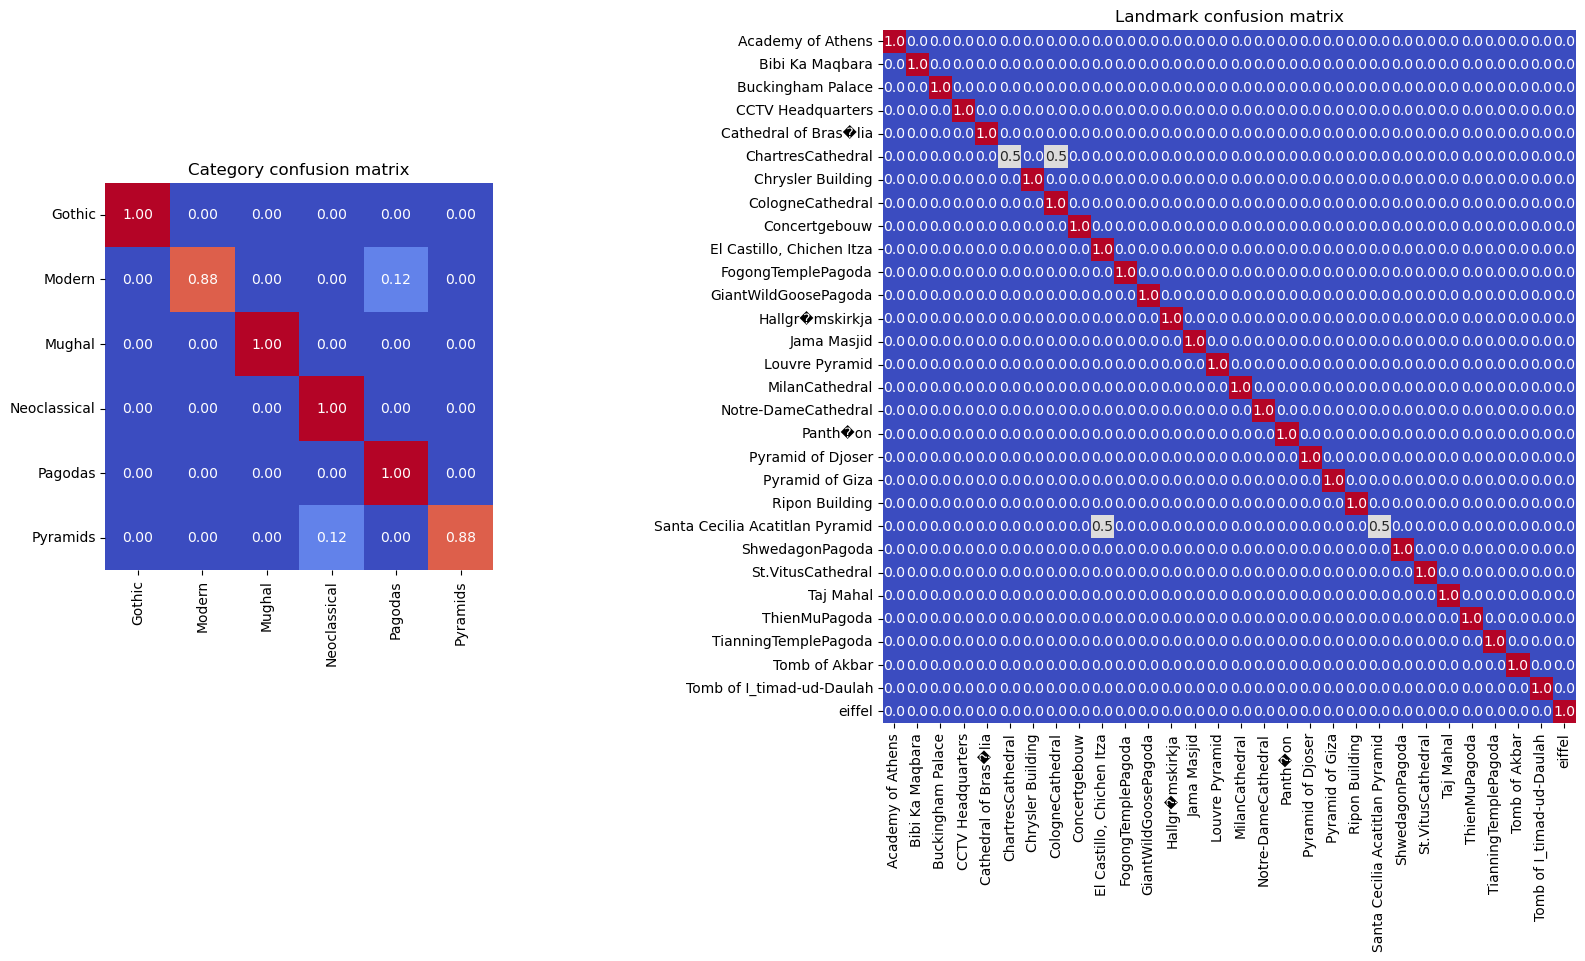

time: 6.06 s (started: 2023-04-30 00:55:58 +00:00)


In [24]:
cat_preds, land_preds = model.predict(test_x)

cat_confusion = confusion_matrix(
    np.argmax(cat_y_test, axis = 1), 
    np.argmax(cat_preds, axis = 1)
)
cat_confusion = cat_confusion / cat_confusion.sum(axis=1)[:, np.newaxis]

land_confusion = confusion_matrix(
    np.argmax(land_y_test, axis = 1), 
    np.argmax(land_preds, axis = 1)
)
land_confusion = land_confusion / land_confusion.sum(axis=1)[:, np.newaxis]

# Plotting confusion matrices
fig = plt.subplots(1,2,figsize=(22,9), gridspec_kw={'width_ratios': [1, 3]})

# Category confusion matrix plot
plt.subplot(121)
cat_l = list(lb_category.classes_)
sns.heatmap(
    cat_confusion, square = True, annot = True, fmt = '.2f', cbar = False, 
    xticklabels = cat_l, yticklabels = cat_l, cmap = 'coolwarm'
).set_title('Category confusion matrix')

# Color confusion matrix plot
plt.subplot(122)
land_l = list(lb_landmark.classes_)
sns.heatmap(
    land_confusion, square = True, annot = True, fmt = '.1f', cbar = False, 
    xticklabels = land_l, yticklabels = land_l, cmap = 'coolwarm'
).set_title('Landmark confusion matrix')

plt.show()

In [25]:
print("Classification report for Category")
print(
    classification_report(
        np.argmax(cat_y_test, axis = 1), 
        np.argmax(cat_preds, axis = 1)
    )
)

print("Classification report for Landmarks")
print(
    classification_report(
        np.argmax(land_y_test, axis = 1), 
        np.argmax(land_preds, axis = 1)
    )
)

Classification report for Category
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      0.88      0.93         8
           2       1.00      1.00      1.00         7
           3       0.88      1.00      0.93         7
           4       0.83      1.00      0.91         5
           5       1.00      0.88      0.93         8

    accuracy                           0.95        42
   macro avg       0.95      0.96      0.95        42
weighted avg       0.96      0.95      0.95        42

Classification report for Landmarks
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         1
           5       1.00      0.50      0.67         2
       

In [26]:
model.evaluate(test_dataset)

2/2 [==============================] - 0s 35ms/step - loss: 0.3881 - category_loss: 0.1090 - landmark_loss: 0.2791 - category_f1_score: 0.9515 - landmark_f1_score: 0.9600


[0.3881421387195587,
 0.10901308059692383,
 0.2791290283203125,
 array([1.        , 0.93333334, 1.        , 0.93333334, 0.90909094,
        0.93333334], dtype=float32),
 array([1.       , 1.       , 1.       , 1.       , 1.       , 0.6666667,
        1.       , 0.8      , 1.       , 0.6666667, 1.       , 1.       ,
        1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 1.       , 0.6666667, 1.       , 1.       ,
        1.       , 1.       , 1.       , 1.       , 1.       , 1.       ],
       dtype=float32)]

time: 267 ms (started: 2023-04-30 00:56:04 +00:00)


# Plotting Confidence

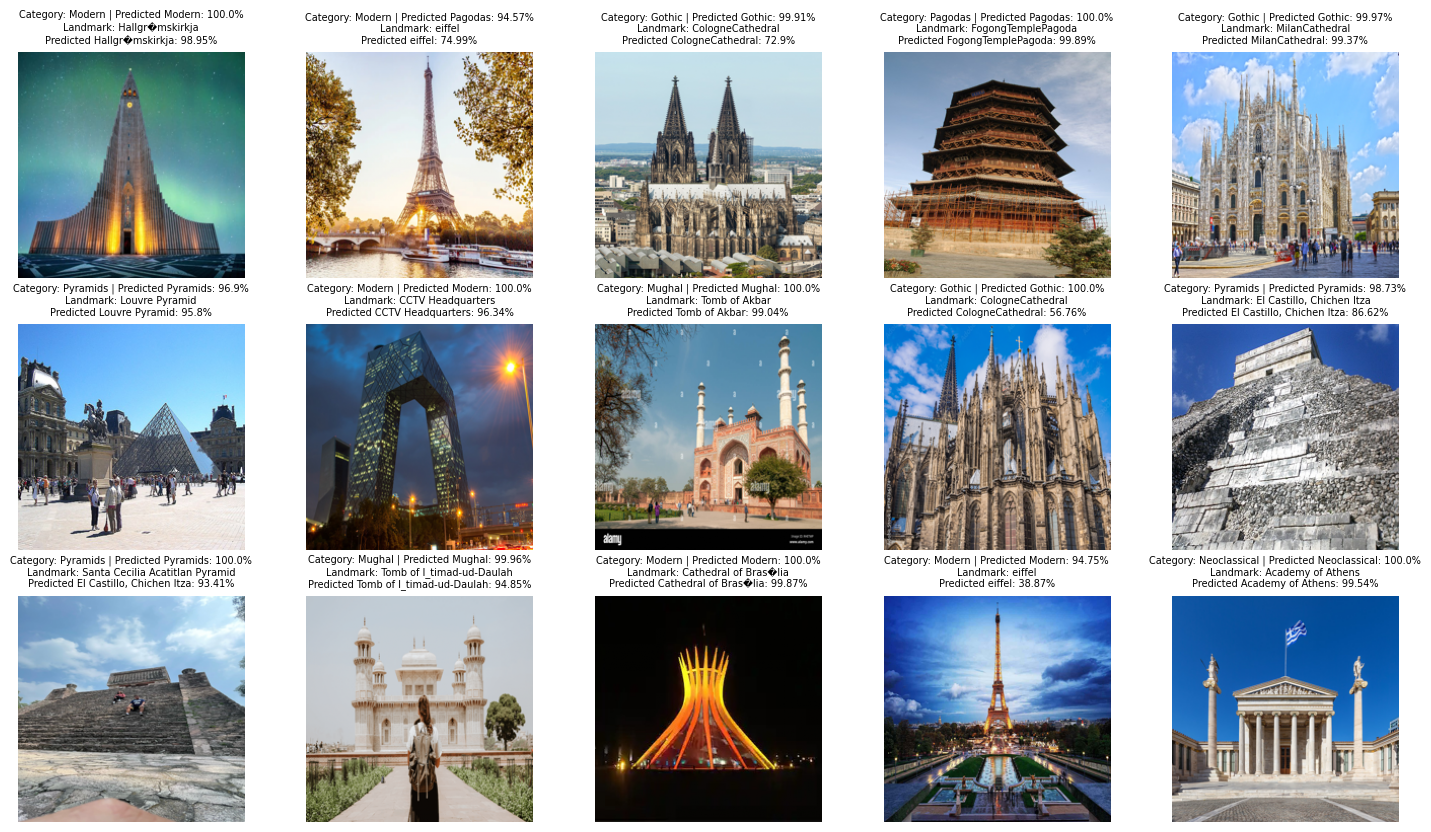

time: 2.8 s (started: 2023-04-30 00:56:05 +00:00)


In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))
for images, labels in test_dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        image = images[i].numpy()
        plt.imshow(image)
        
        resized = cv2.resize(image, (INPUT_SHAPE[1], INPUT_SHAPE[0]))
        resized = image.reshape(-1, INPUT_SHAPE[1], INPUT_SHAPE[0], INPUT_SHAPE[2])
        
        # Predict results
        preds_cat, preds_land = model.predict(resized, verbose=0)
        preds_cat = (lb_category.classes_[np.argmax(preds_cat[0])], round(preds_cat[0].max() * 100, 2))
        preds_land = (lb_landmark.classes_[np.argmax(preds_land[0])], round(preds_land[0].max() * 100, 2))
        
        cat_ = lb_category.classes_[np.argmax(labels["category"][i])]
        land_ = lb_landmark.classes_[np.argmax(labels["landmark"][i])]
        
        plt.title(
            f"""Category: {cat_} | Predicted {preds_cat[0]}: {preds_cat[1]}%\nLandmark: {land_}\nPredicted {preds_land[0]}: {preds_land[1]}%""",
            fontdict={"fontsize":7})
        plt.axis("off")

# Load the saved Model

In [28]:
saved_model = tf.keras.models.load_model(
    "clc_classifier_model_tf28.h5", custom_objects={"KerasLayer": hub.KerasLayer})
saved_model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 image_augmentation (Sequential  (None, 224, 224, 3)  0          ['input_1[0][0]']                
 )                                                                                                
                                                                                                  
 efficientnet_b0 (KerasLayer)   (None, 1280)         4049564     ['image_augmentation[0][0]']     
                                                                                       

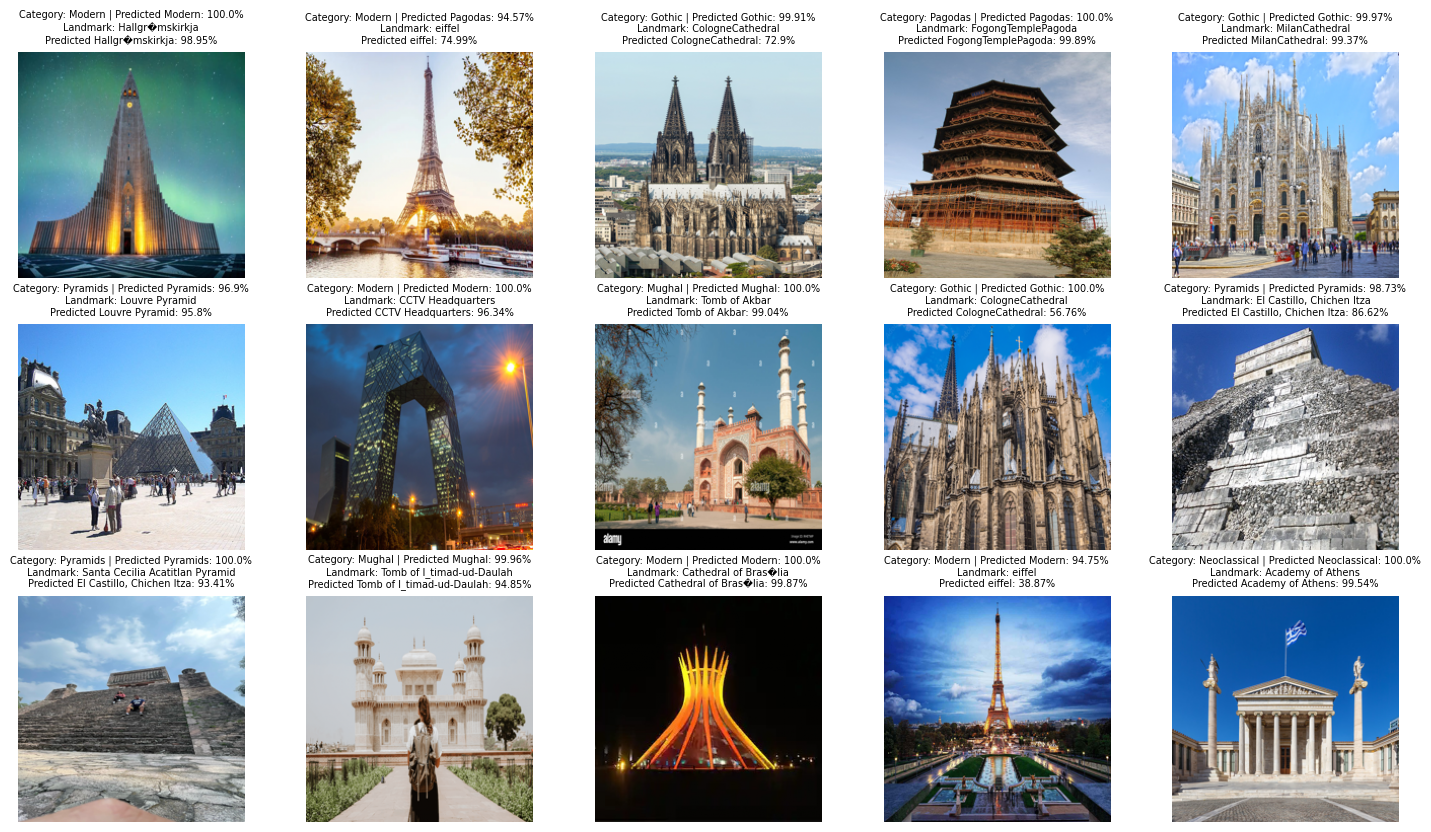

time: 3.77 s (started: 2023-04-30 00:56:20 +00:00)


In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))
for images, labels in test_dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        image = images[i].numpy()
        plt.imshow(image)
        
        resized = cv2.resize(image, (INPUT_SHAPE[1], INPUT_SHAPE[0]))
        resized = image.reshape(-1, INPUT_SHAPE[1], INPUT_SHAPE[0], INPUT_SHAPE[2])
        
        # Predict results
        preds_cat, preds_land = saved_model.predict(resized, verbose=0)
        preds_cat = (lb_category.classes_[np.argmax(preds_cat[0])], round(preds_cat[0].max() * 100, 2))
        preds_land = (lb_landmark.classes_[np.argmax(preds_land[0])], round(preds_land[0].max() * 100, 2))
        
        cat_ = lb_category.classes_[np.argmax(labels["category"][i])]
        land_ = lb_landmark.classes_[np.argmax(labels["landmark"][i])]
        
        plt.title(
            f"""Category: {cat_} | Predicted {preds_cat[0]}: {preds_cat[1]}%\nLandmark: {land_}\nPredicted {preds_land[0]}: {preds_land[1]}%""",
            fontdict={"fontsize":7})
        plt.axis("off")

# END